# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

---
#**Personal Info:**
*   **Student:**
    *   Sherlon Almeida da Silva
*   **Affiliation:**
    *   PhD Student
    *   University of São Paulo (USP)
    *   Institute of Mathematics and Computer Science (ICMC)
    *   Laboratory of Visualization, Imaging and Computer Graphics (VICG)
*   **Research & Programming:**
    *   [Lattes](http://lattes.cnpq.br/0000096258045504) | [ORCID](https://orcid.org/0000-0001-6124-9350) | [Google Scholar](https://scholar.google.com.br/citations?user=boFxo4gAAAAJ&hl=pt-BR) | [Linkedin](https://www.linkedin.com/in/SherlonAlmeida/) | [Github](https://github.com/SherlonAlmeida) | [Personal Page](http://vicg.icmc.usp.br/vicg/person/72/sherlon-almeida-da-silva)
---

# Lab Class #2 - Learning Signals

In this practice, we are going to verify many of the concepts studied in the class "Learning Signals". If you need to recall the theory, check the video below.

In [2]:
#@title
from IPython.display import IFrame
IFrame(src='https://www.youtube.com/embed/OcxvX4bMnzk', width='560', height='315')

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import imageio

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.transforms.functional import to_tensor, to_pil_image
from collections import OrderedDict
import numpy as np
import skimage
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.fft import fft, fftfreq
from typing import Sequence, Tuple, Union

import time

import seaborn as sns

In [4]:
#Definir a seed permite gerar os mesmos dados pseudoaleatórios (Replicabilidade)
torch.manual_seed(777)
sns.set_theme()

# 1 Sampling and Reconstruction

We are going to start working with 1D signals in the interval $[-1, 1]$. Shannon theorem states some conditions for reconstruction of bandlimited signals after uniform sampling. Let's verify it in practice.

In [5]:
def get_mgrid(sidelen, dim=2, start=-1, end=1):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(start, end, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid #Retorna um grid do intervalo estabelecido

class Signal1D(Dataset):
    def __init__(self, coords, values):
        super().__init__()
        self.values = values.view(-1, 1)
        self.coords = coords

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.values

def sinusoidal(nsamples, freqs, biases=None):
    coords = get_mgrid(nsamples, 1).view(-1)
    values = torch.zeros(nsamples)
    if biases is None:
      biases = torch.zeros(len(freqs))
    for freq, bias in zip(freqs, biases):
      values = values + torch.sin(freq * coords + bias)
    return Signal1D(coords, values)

def plot_signals(signals:Union[Signal1D, Sequence[Signal1D]]):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    lines = ['-', '--', '-.', ':']
    fig, ax = plt.subplots(figsize=(16, 8))
    if not isinstance(signals, Sequence):
      signals = [signals]
    for i, signal in enumerate(signals):
        ax.plot(signal.coords, 
                signal.values, 
                label=f'S{i}', color=COLORS[i%len(COLORS)])
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')

    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

## 1.1 Uniform Sampling

Let's take some samples of continuous functions uniformly over the interval $[-1, 1]$ an plot them. To make it easier to see we are working with bandlimited signals, we are going to start with combinations of sinusoidal functions, so we know the exact the frequency content of the signal.

In [6]:
def plot_samples1D(func, nsamples, width=14, height=7):
    x = get_mgrid(nsamples, 1)
    samples = func(x)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(x, samples, 'o', label=f'Uniform samples')
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

def multi_plot(dots, curves=[], labels=[], width=14, height=7):
    fig, ax = plt.subplots(figsize=(width, height))
    ax.plot(*dots, 'o', label=f'Uniform samples')
    for i, (x, y) in enumerate(curves):
        ax.plot(x, y, label=labels[i])

    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    # remove the ticks from the top and right edges
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    plt.legend()

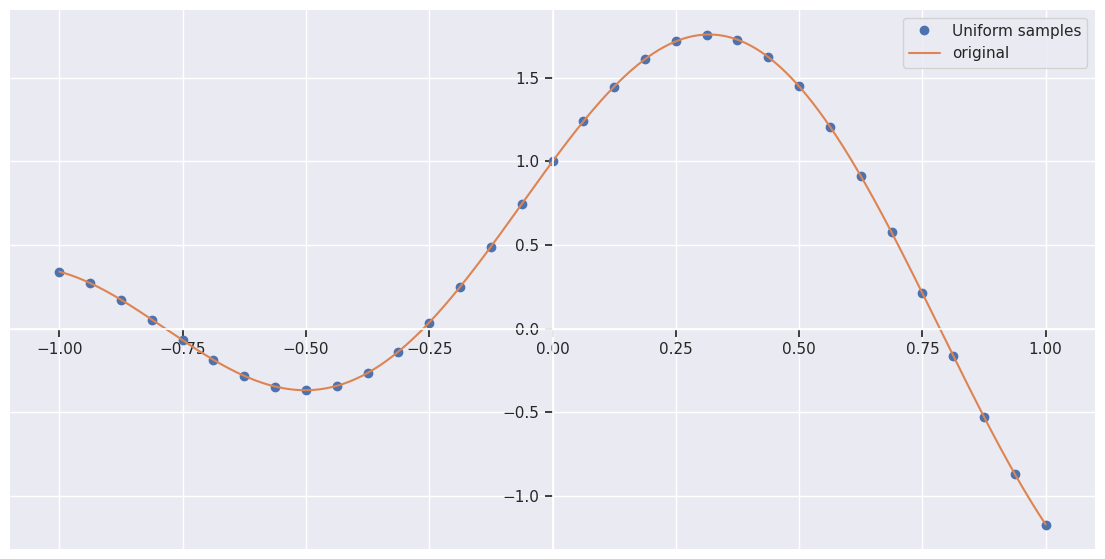

In [7]:
#Realiza a amostragem de uma função
gridres = 1025
nsamples = 33
signal = lambda x: (np.cos(2 * x) + np.sin(4 * x))
full_grid    = get_mgrid(gridres,  1) #Amostra 1025 pontos da função (ou seja, tem maior resolução do sinal, é mais suave)
samples_grid = get_mgrid(nsamples, 1) #Amostra 33 pontos da função (tem menor resolução do sinal)

#Plota a função (sinal gerado) e os respectivos 33 pontos amostrados
multi_plot((samples_grid, signal(samples_grid)), #Gera os 33 pontos (x, y) azuis
           [(full_grid, signal(full_grid))],     #Gera o sinal, que também é discreto, porém é muito mais suave por ter mais pontos, neste caso 1025.
           ['original'])                         #Passa o texto para a legenda

## 1.2 Reconstruction

* **Part I)** Implement a function to reconstruct a signal sampled uniformly using the Shanon basis, that is the function $sinc(x) = \frac{sin(x)}{x}$. Plot the original signal and the reconstructed signal (sample more points) in the same graph. Did it work? Why?

* **Part II)** Reduce the sampling rate until it's below the Nyquist limit. What happens when you try to reconstruct the signal? Alternatively, you may add higher frequencies to the signal.

* **Part III)** Try again with a signal composed of more frequencies.

### **Part I**

In [8]:
#Adaptado de: https://cmps-people.ok.ubc.ca/jbobowsk/Python/html/Jupyter%20Nyquist%20Reconstruction.html
def shannon_reconstruction(t, y, S, T, F):
    reconstruction = 0
    for i in range(-int((S-1)/2), int((S-1)/2), 1):
        n = int(i + (S-1)/2 + 1)
        reconstruction += y[n]*np.sin(np.pi*F*(t - i*T))/(np.pi*F*(t - i*T))
    return reconstruction

In [9]:
#Realiza a amostragem de uma função
gridres, nsamples, n_reconst = 2000, 100, 2000 #(discretização do sinal original, amostras geradas do sinal original, amostras do sinal reconstruido)
start_value, end_value = -1, 1                #Intervalo

#Define a função
signal = lambda x: (np.cos(2 * x) + np.sin(4 * x))

#Criando o sinal original
full_grid_x    = get_mgrid(gridres,  dim=1, start=start_value, end=end_value)  #Plota vários pontos do sinal original (ou seja, tem maior resolução, é mais suave, simulando a função contínua)
full_grid_y    = torch.reshape(signal(full_grid_x), (-1,))

#Amostrando o sinal original
samples_grid_x = get_mgrid(nsamples, dim=1, start=start_value, end=end_value)  #Amostra pontos do sinal original (tem menor resolução do sinal)
samples_grid_y = torch.reshape(signal(samples_grid_x), (-1,))

#Reconstruindo o sinal original
reconst_grid_x = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x = torch.reshape(reconst_grid_x, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/nsamples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'nsamples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

In [10]:
reconst_grid_y = shannon_reconstruction(reconst_grid_x, samples_grid_y, nsamples, T, F)

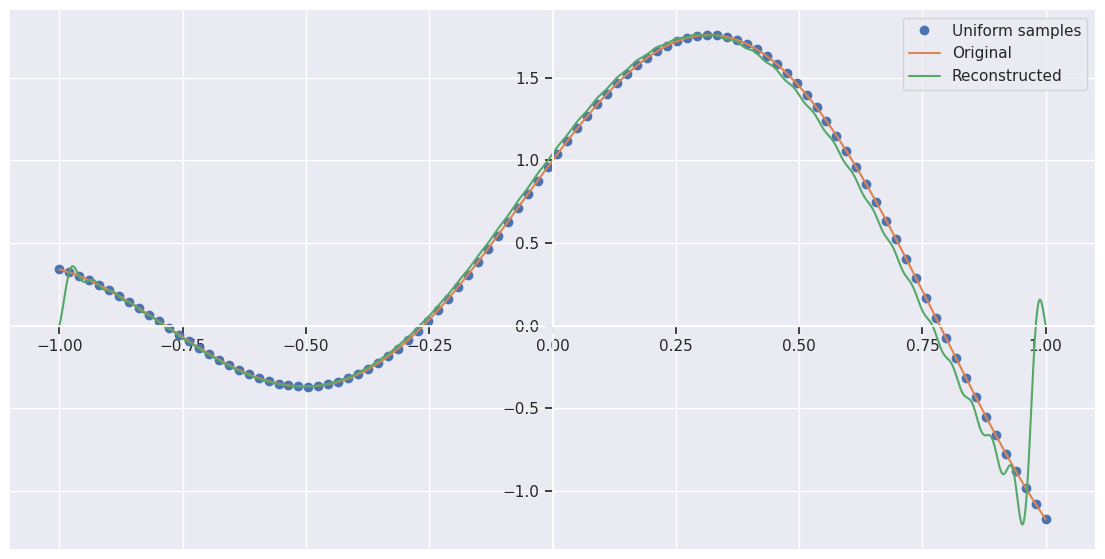

In [11]:
#Plota a função (sinal gerado)
multi_plot((samples_grid_x, samples_grid_y),
           [(full_grid_x, full_grid_y), (reconst_grid_x, reconst_grid_y)],
           ['Original', 'Reconstructed'])

#### **Conclusions:**

**Task:** Implement a function to reconstruct a signal sampled uniformly using the Shanon basis, that is the function $sinc(x) = \frac{sin(x)}{x}$. Plot the original signal and the reconstructed signal (sample more points) in the same graph. Did it work? Why?

**Observations:** The Nyquist-Shannon theorem states that if we sample a signal such that we have at least 1 point every half period (or 2 points per cycle), we can fully reconstruct the signal without any losses. The experiment above has shown that the signal was reconstructed properly according to the Nyquist-Shannon theorem.

### **Part II**

In [12]:
#Realiza a amostragem de uma função
gridres, nsamples, n_reconst = 2000, 8, 2000 #(discretização do sinal original, amostras geradas do sinal original, amostras do sinal reconstruido)
start_value, end_value = -1, 1                #Intervalo

#Define a função
signal = lambda x: (np.cos(12 * x) + np.sin(8 * x))

#Criando o sinal original
full_grid_x    = get_mgrid(gridres,  dim=1, start=start_value, end=end_value)  #Plota vários pontos do sinal original (ou seja, tem maior resolução, é mais suave, simulando a função contínua)
full_grid_y    = torch.reshape(signal(full_grid_x), (-1,))

#Amostrando o sinal original
samples_grid_x = get_mgrid(nsamples, dim=1, start=start_value, end=end_value)  #Amostra pontos do sinal original (tem menor resolução do sinal)
samples_grid_y = torch.reshape(signal(samples_grid_x), (-1,))

#Reconstruindo o sinal original
reconst_grid_x = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x = torch.reshape(reconst_grid_x, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/nsamples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'nsamples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

In [13]:
reconst_grid_y = shannon_reconstruction(reconst_grid_x, samples_grid_y, nsamples, T, F)

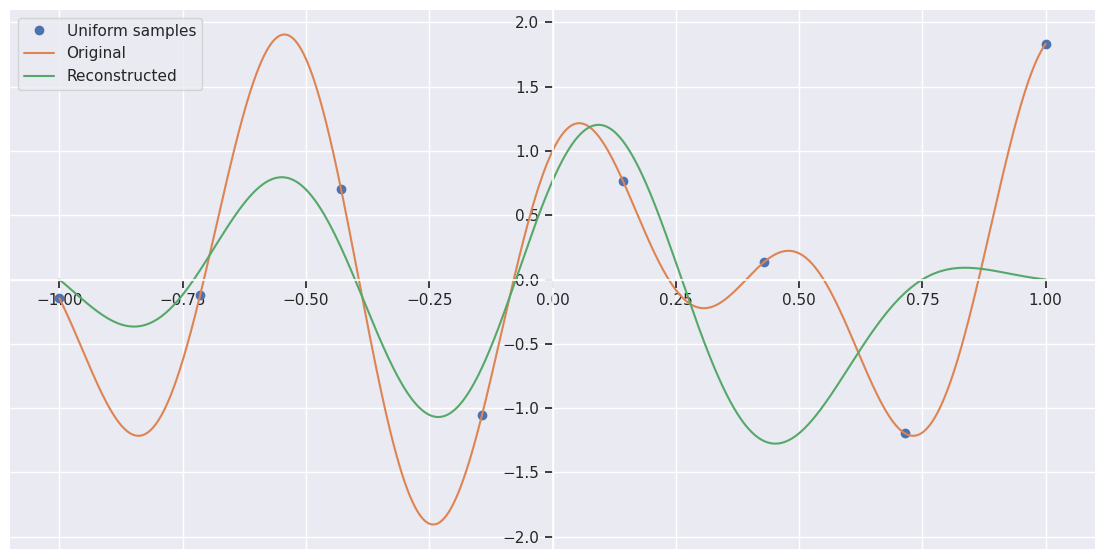

In [14]:
#Plota a função (sinal gerado)
multi_plot((samples_grid_x, samples_grid_y),
           [(full_grid_x, full_grid_y), (reconst_grid_x, reconst_grid_y)],
           ['Original', 'Reconstructed'])

#### **Conclusions:**

**Task:** Reduce the sampling rate until it's below the Nyquist limit. What happens when you try to reconstruct the signal? Alternatively, you may add higher frequencies to the signal.

**Observations:** By increasing the frequency of the signal and reducing the number of samples below the minimum Nyquist frequency, it is possible to observe a reconstruction error. In other words, the signal was not adequately preserved, resulting in inaccurate reconstruction.

### **Part III**

In [15]:
#Realiza a amostragem de uma função
gridres, nsamples, n_reconst = 2000, 8, 2000 #(discretização do sinal original, amostras geradas do sinal original, amostras do sinal reconstruido)
start_value, end_value = -1, 1                #Intervalo

#Define a função
signal = lambda x: (np.sin(30 * np.pi * x) * np.exp(x) + np.cos(10 * np.pi * x))

#Criando o sinal original
full_grid_x    = get_mgrid(gridres,  dim=1, start=start_value, end=end_value)  #Plota vários pontos do sinal original (ou seja, tem maior resolução, é mais suave, simulando a função contínua)
full_grid_y    = torch.reshape(signal(full_grid_x), (-1,))

#Amostrando o sinal original
samples_grid_x = get_mgrid(nsamples, dim=1, start=start_value, end=end_value)  #Amostra pontos do sinal original (tem menor resolução do sinal)
samples_grid_y = torch.reshape(signal(samples_grid_x), (-1,))

#Reconstruindo o sinal original
reconst_grid_x = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x = torch.reshape(reconst_grid_x, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/nsamples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'nsamples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

In [16]:
reconst_grid_y = shannon_reconstruction(reconst_grid_x, samples_grid_y, nsamples, T, F)

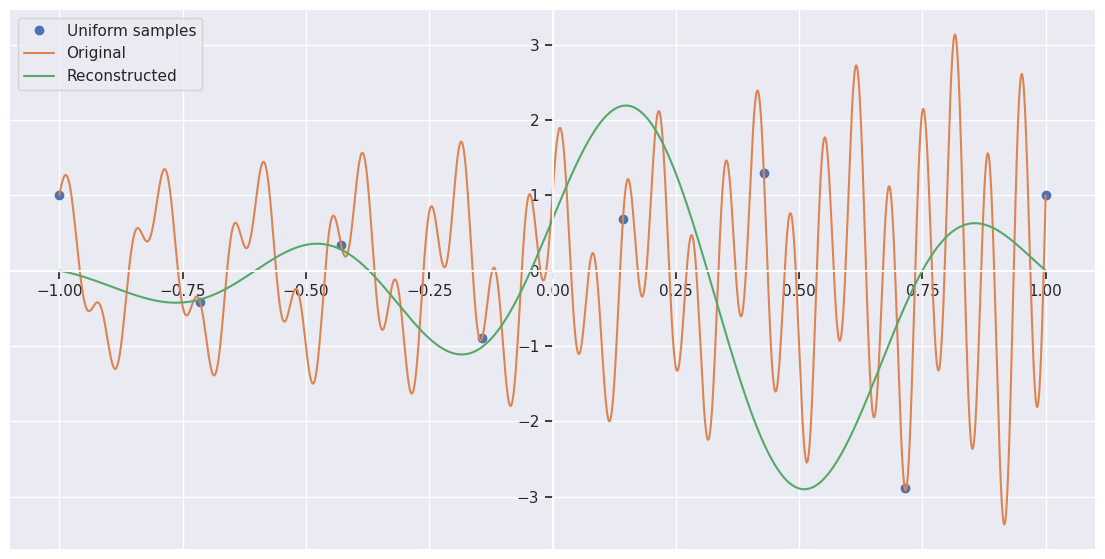

In [17]:
#Plota a função (sinal gerado)
multi_plot((samples_grid_x, samples_grid_y),
           [(full_grid_x, full_grid_y), (reconst_grid_x, reconst_grid_y)],
           ['Original', 'Reconstructed'])

#### **Conclusions:**

**Task:** Try again with a signal composed of more frequencies.

**Observations:** The same observation occurred again, as it is necessary to sample the original signal at least twice per cycle, according to the Nyquist-Shannon Theorem, to reconstruct the signal without any losses.

## 1.3 Fourier Transform

The code below allows you to plot the Fast Fourier Transform of a signal, and check its representation in the frequency domain.

In [18]:
def plot_fft1D(signals, width=16, height=8):
    COLORS = ['blue', 'orange', 'green', 'purple', 'pink']
    lines = ['-', '--', '-.', ':']
    if not isinstance(signals, Sequence):
      signals = [signals]
    fig, ax = plt.subplots(figsize=(width, height))
    for i, signal in enumerate(signals):
        W = signal.values.view(-1).cpu().detach().numpy()
        N = len(W)
        yf = fft(W)
        xf = fftfreq(N, 2/N)[:N//2]
        ax.plot(xf, 2.0/N * np.abs(yf[0:N//2]), 
                label=f'S{i}', color=COLORS[i%len(COLORS)])
    plt.legend()

In [19]:
#Realiza a amostragem de uma função
gridres, n_reconst = 2000, 2000 #(discretização do sinal original, amostras do sinal reconstruido)
start_value, end_value = -1, 1                #Intervalo

#Define a função
signal = lambda x: (np.sin(10 * np.pi * x) * np.exp(x) + np.cos(5 * np.pi * x))

#Criando o sinal original
full_grid_x    = get_mgrid(gridres,  dim=1, start=start_value, end=end_value)  #Plota vários pontos do sinal original (ou seja, tem maior resolução, é mais suave, simulando a função contínua)
full_grid_y    = torch.reshape(signal(full_grid_x), (-1,))

In [20]:
#Amostrando o sinal original (Com amostras INSUFICIENTES, ou seja, menor do que o limite de Nyquist)
nsamples = 10
samples_grid_x1 = get_mgrid(nsamples, dim=1, start=start_value, end=end_value)  #Amostra pontos do sinal original (tem menor resolução do sinal)
samples_grid_y1 = torch.reshape(signal(samples_grid_x1), (-1,))

#Reconstruindo o sinal original
reconst_grid_x1 = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x1 = torch.reshape(reconst_grid_x1, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/nsamples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'nsamples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

reconst_grid_y1 = shannon_reconstruction(reconst_grid_x1, samples_grid_y1, nsamples, T, F)

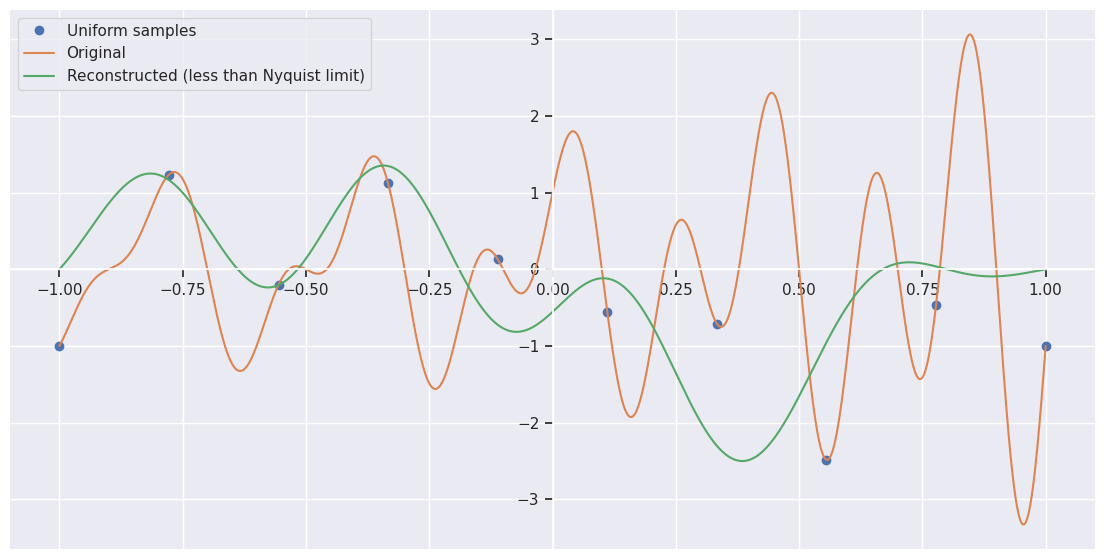

In [21]:
#Plota a função (sinal gerado)
multi_plot((samples_grid_x1, samples_grid_y1),
           [(full_grid_x, full_grid_y), (reconst_grid_x1, reconst_grid_y1)],
           ['Original', 'Reconstructed (less than Nyquist limit)'])

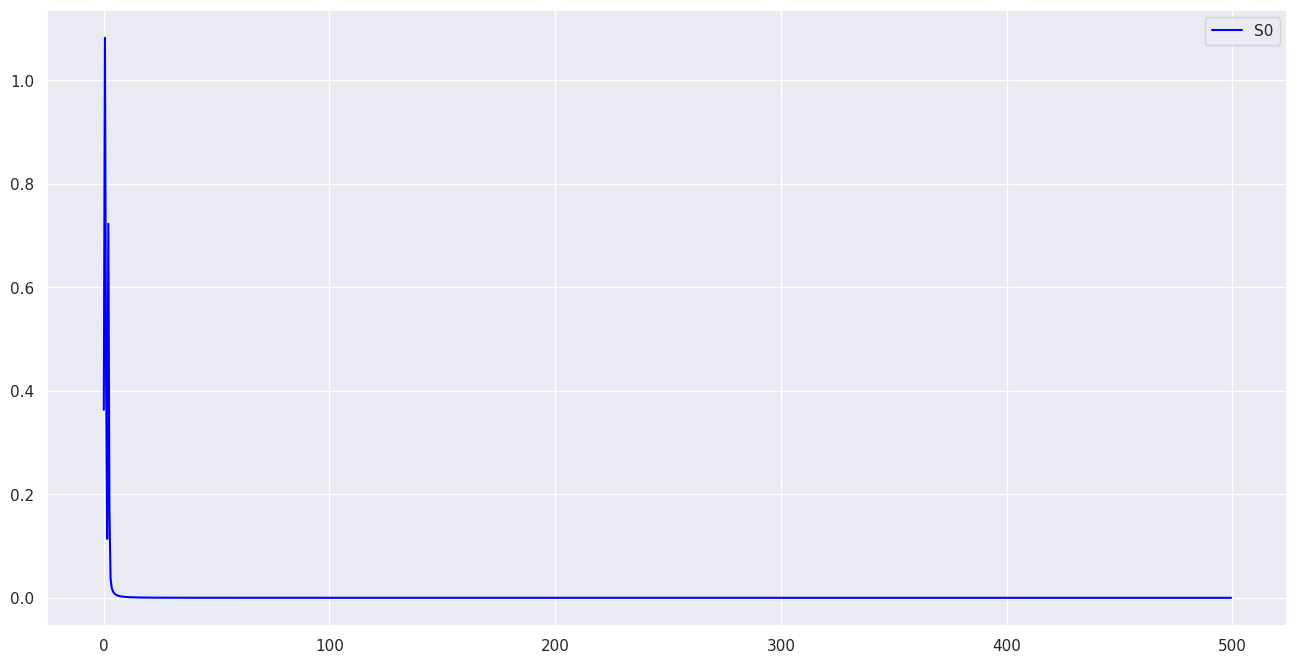

In [22]:
#Mostrando o domínio de frequências do sinal reconstruido com menos amostras do que o limite de Nyquist
lower_than_nyquist = Signal1D(reconst_grid_x1, reconst_grid_y1)
plot_fft1D(lower_than_nyquist)

In [23]:
#Amostrando o sinal original (Com amostras SUFICIENTES, ou seja, maior do que o limite de Nyquist)
nsamples = 80
samples_grid_x2 = get_mgrid(nsamples, dim=1, start=start_value, end=end_value)  #Amostra pontos do sinal original (tem menor resolução do sinal)
samples_grid_y2 = torch.reshape(signal(samples_grid_x2), (-1,))

#Reconstruindo o sinal original
reconst_grid_x2 = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x2 = torch.reshape(reconst_grid_x2, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/nsamples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'nsamples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

reconst_grid_y2 = shannon_reconstruction(reconst_grid_x2, samples_grid_y2, nsamples, T, F)

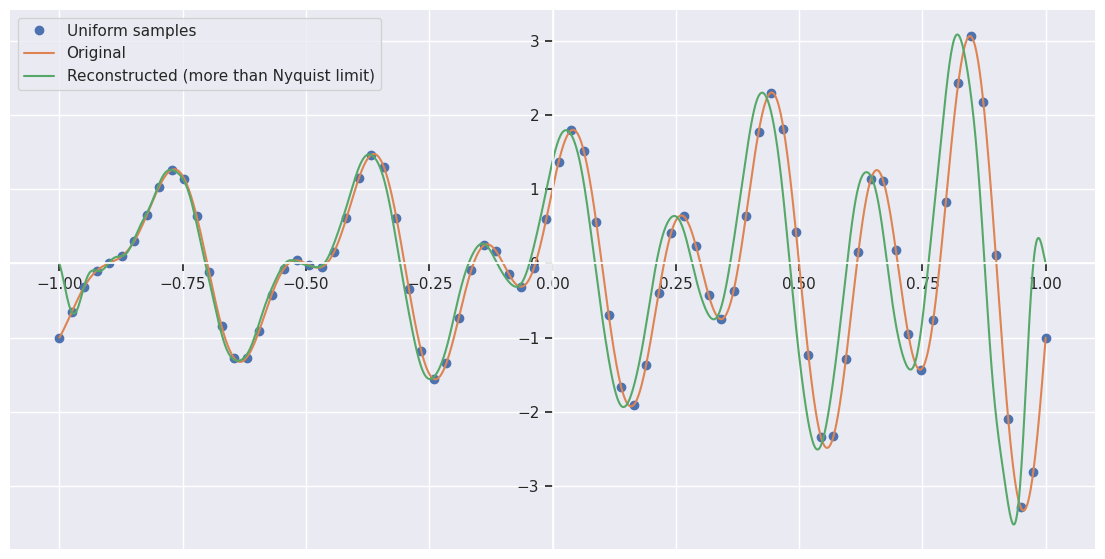

In [24]:
#Plota a função (sinal gerado)
multi_plot((samples_grid_x2, samples_grid_y2),
           [(full_grid_x, full_grid_y), (reconst_grid_x2, reconst_grid_y2)],
           ['Original', 'Reconstructed (more than Nyquist limit)'])

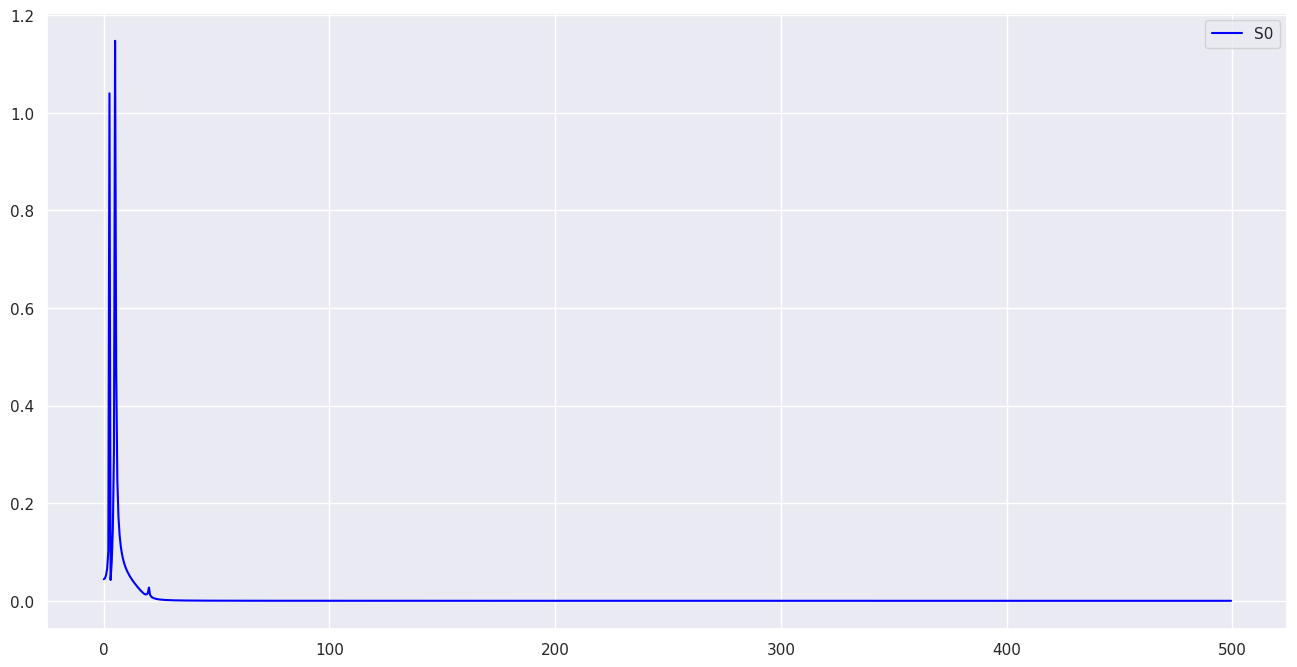

In [25]:
#Mostrando o domínio de frequências do sinal reconstruido com mais amostras do que o limite de Nyquist
greater_than_nyquist = Signal1D(reconst_grid_x2, reconst_grid_y2)
plot_fft1D(greater_than_nyquist)

#### **Conclusions:**

**Task:** Based on the experiments you did on the previous section, use the FFT algorithm to compare the frequencies present in the original signal and its reconstruction. Check it when you have a sampling rate above the Nyquist limit, and also when it's below this limit. Do you see anything interesting?

**Observations:** The behavior of the signal reconstructed with the appropriate number of samples appears to be better defined, presenting frequencies with more detail than the signal with samples below the Nyquist limit.

# 2 Aliasing

We saw that Aliasing is an effect that causes higher frequencies to be interpreted as lower frequencies under certain conditions. We are going to check how aliasing artifacts look like when we are working with 1D and 2D signals.

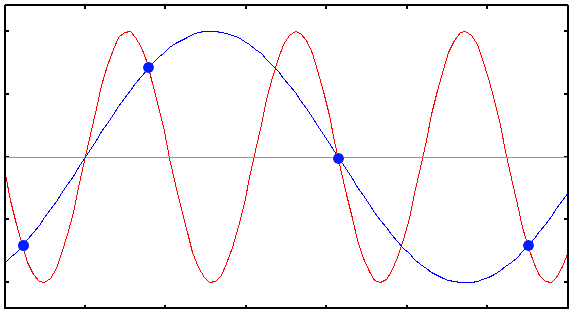

## 2.1 Spoting aliasing artifacts

Perlin Noise is a kind of stochastic signal with large applications in procedural modeling in computer graphics. We are going to use it to generate more sophisticated signals for the next exercise.

In [26]:
def blend(x):
  return 6*x**5 - 15*x**4 + 10*x**3

def noise(scale, samples):
    # create a list of 2d vectors
    angles = torch.rand(scale) * 2*torch.pi
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=1)

    x = torch.linspace(0, scale-1, samples)
    noise_values = []
    for value in x[:-1]:
        i = torch.floor(value).long()
        lower, upper = gradients[i], gradients[i+1]

        dot1 = torch.dot(lower, torch.tensor([value - i, 0]))
        dot2 = torch.dot(upper, torch.tensor([value - i - 1, 0]))
        # TODO: review interpolation
        k1 = blend(value-i)
        k2 = blend(i+1 - value)
        interpolated = k1*dot2 + k2*dot1 
        noise_values.append(interpolated.item())
    
    noise_values.append(0.0)
    return torch.tensor(noise_values)

def perlin_noise(nsamples, scale=10, octaves=1, p=1):
    pnoise = 0
    for i in range(octaves):
        partial = noise(2**i * scale, nsamples)/(p**i)
        pnoise = partial + pnoise
    return Signal1D(get_mgrid(nsamples, 1), pnoise)

* Generate some Perlin Noise signals exploring different setting of its parameters. When you have an idea of how it works, choose one that presents fine details. Plot the signal and its FFT. Analyze what you see.

In [27]:
#Gerando alguns sinais para observar o comportamento do parâmetro "octaves"
p_noise1 = perlin_noise(1000, scale=10, octaves=1, p=1)
p_noise2 = perlin_noise(1000, scale=10, octaves=2, p=1)
p_noise3 = perlin_noise(1000, scale=10, octaves=3, p=1)
p_noise4 = perlin_noise(1000, scale=10, octaves=4, p=1)

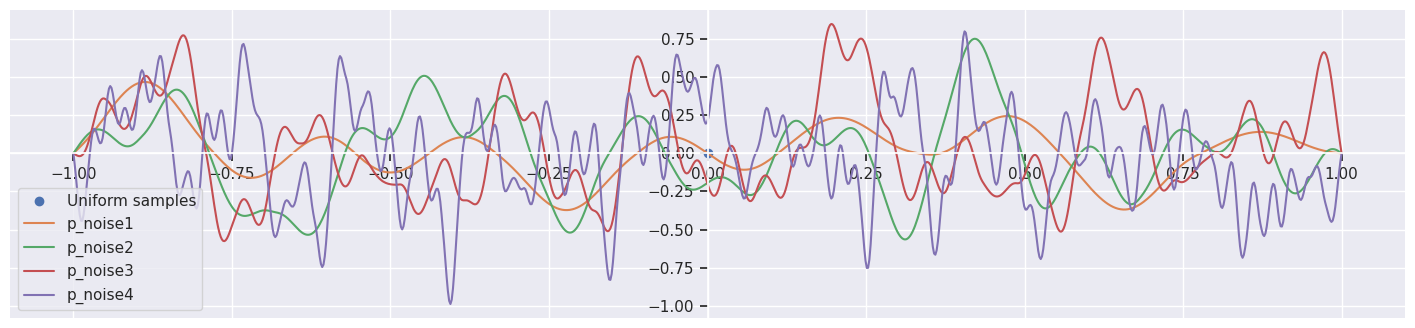

In [28]:
#Plotando os sinais ruidosos gerados (Domínio espacial)
multi_plot((0, 0),
           [(p_noise1.coords, p_noise1.values), (p_noise2.coords, p_noise2.values), (p_noise3.coords, p_noise3.values), (p_noise4.coords, p_noise4.values)],
           ['p_noise1', 'p_noise2', 'p_noise3', 'p_noise4'],
           width=18,
           height = 4)

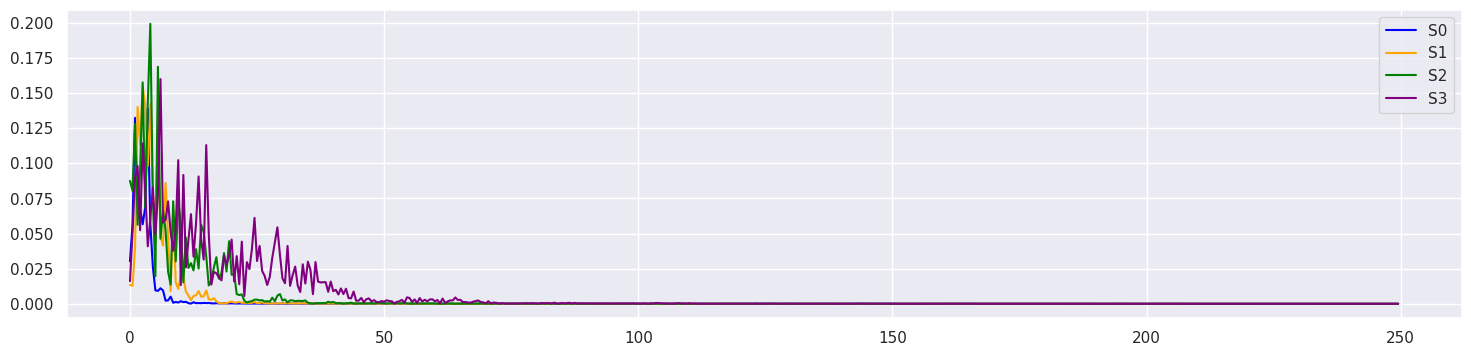

In [29]:
#Plotando os sinais ruidosos gerados (Domínio de Frequência)
plot_fft1D([p_noise1, p_noise2, p_noise3, p_noise4], width=18, height=4)

In [30]:
#Aparentemente os octaves amplificam as frequências do sinal (ESCOLHI octave=4)

In [31]:
#Gerando alguns sinais para observar o comportamento do parâmetro "p"
p_noise1 = perlin_noise(1000, scale=10, octaves=4, p=1)
p_noise2 = perlin_noise(1000, scale=10, octaves=4, p=2)
p_noise3 = perlin_noise(1000, scale=10, octaves=4, p=3)

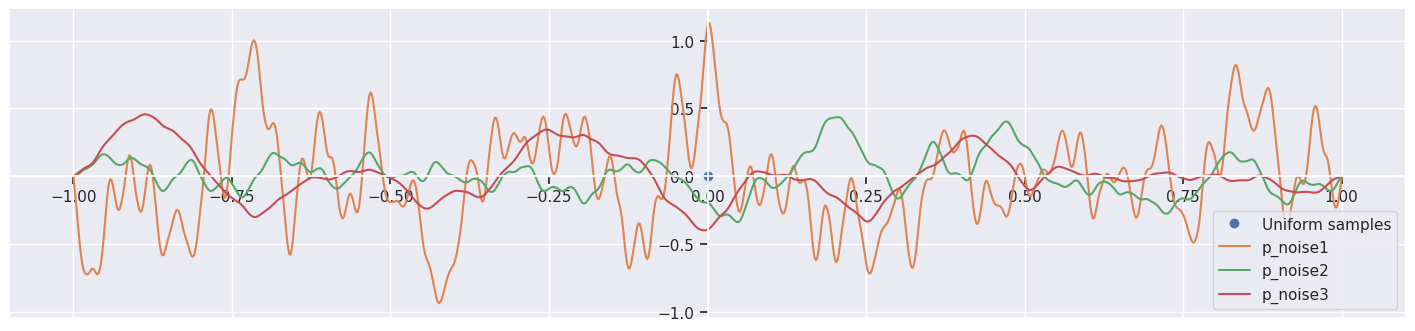

In [32]:
#Plotando os sinais ruidosos gerados (Domínio espacial)
multi_plot((0, 0),
           [(p_noise1.coords, p_noise1.values), (p_noise2.coords, p_noise2.values), (p_noise3.coords, p_noise3.values)],
           ['p_noise1', 'p_noise2', 'p_noise3'],
           width=18,
           height = 4)

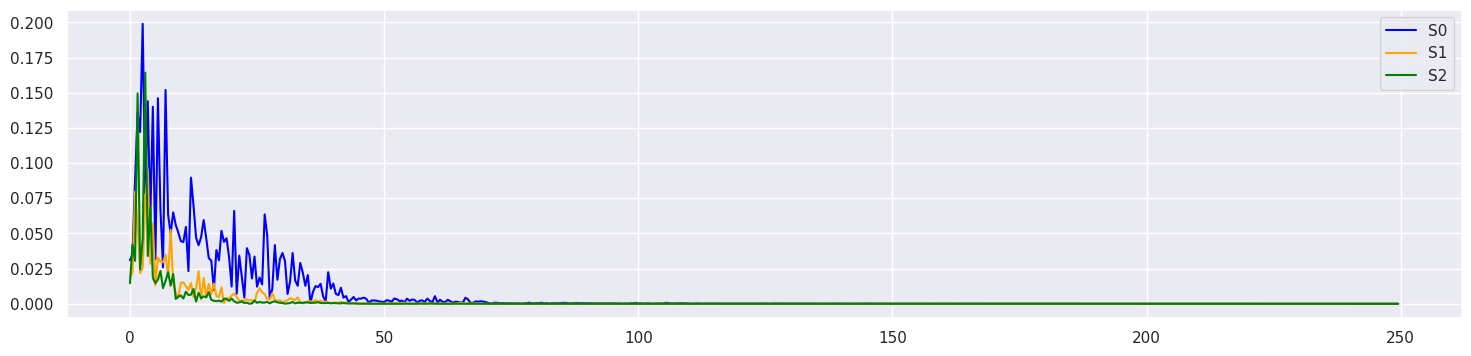

In [33]:
#Plotando os sinais ruidosos gerados (Domínio de Frequências)
plot_fft1D([p_noise1, p_noise2, p_noise3], width=18, height=4)

In [34]:
#Aparentemente o valor de p deforma o sinal, atenuando as frequências (ESCOLHI p = 1)

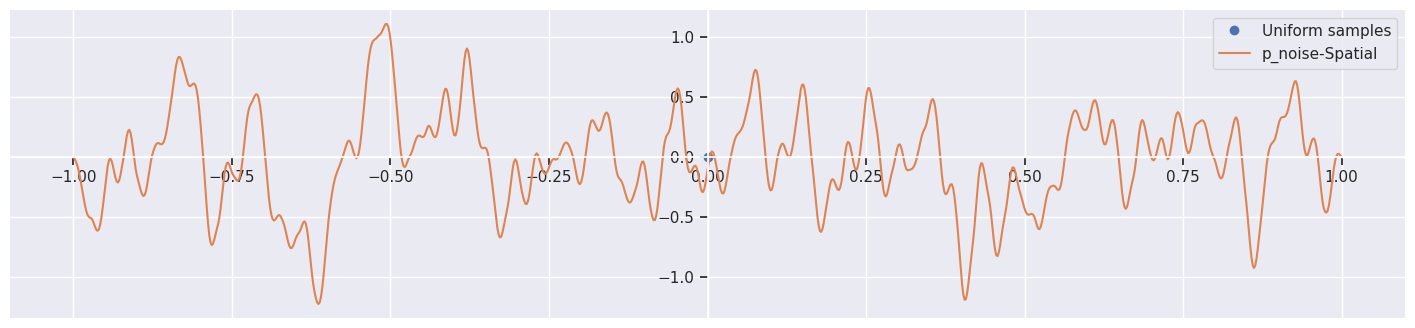

In [35]:
#Criando o sinal escolhido (Domínio Espacial)
n_samples = 1000
p_noise = perlin_noise(n_samples, scale=10, octaves=4, p=1)

multi_plot((0, 0),
           [(p_noise.coords, p_noise.values)],
           ['p_noise-Spatial'],
           width=18,
           height = 4)

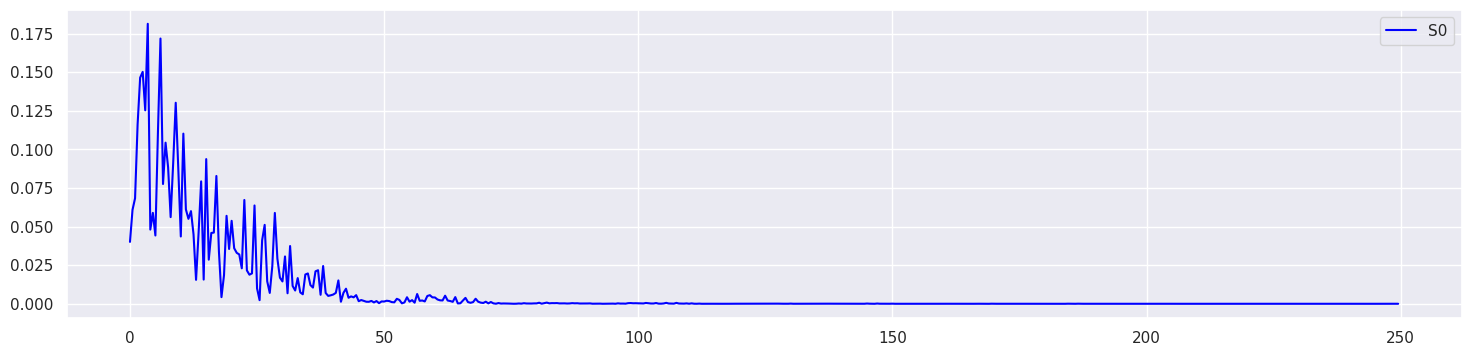

In [36]:
#Criando o sinal escolhido (Domínio de Frequências)
plot_fft1D([p_noise], width=18, height=4)

* Create a new Perlin Noise signal from your previously generated signal by naively subsampling it: just keep 1 sample for every *sumbsampling_factor* samples and ignore the others.

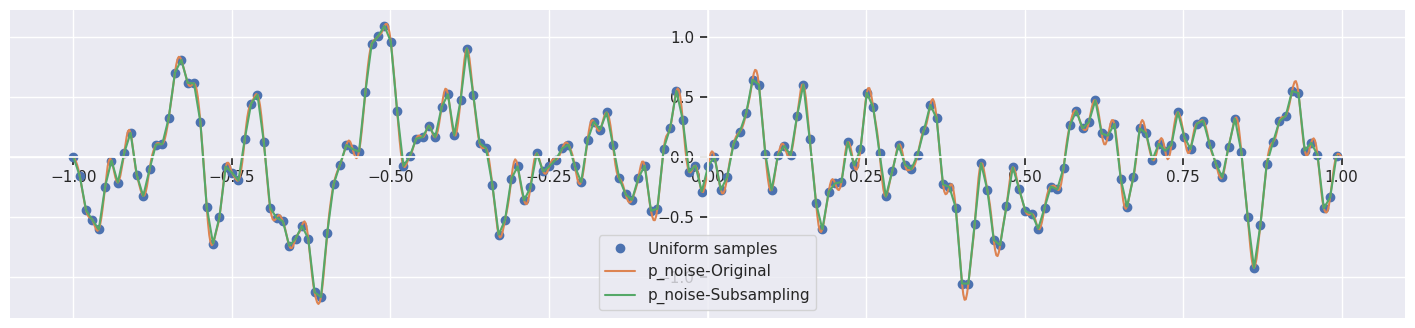

In [37]:
#Amostrando o sinal original
subsampling_factor = 5
subsampling_x = p_noise.coords[::subsampling_factor]
subsampling_y = p_noise.values[::subsampling_factor]
p_noise_subsampling = Signal1D(subsampling_x, subsampling_y)

multi_plot((p_noise_subsampling.coords, p_noise_subsampling.values), #Plotando os pontos amostrados
           [(p_noise.coords, p_noise.values), (p_noise_subsampling.coords, p_noise_subsampling.values)], #Plotando os sinais
           ['p_noise-Original', 'p_noise-Subsampling'], #Plotando as legendas
           width=18,
           height = 4)

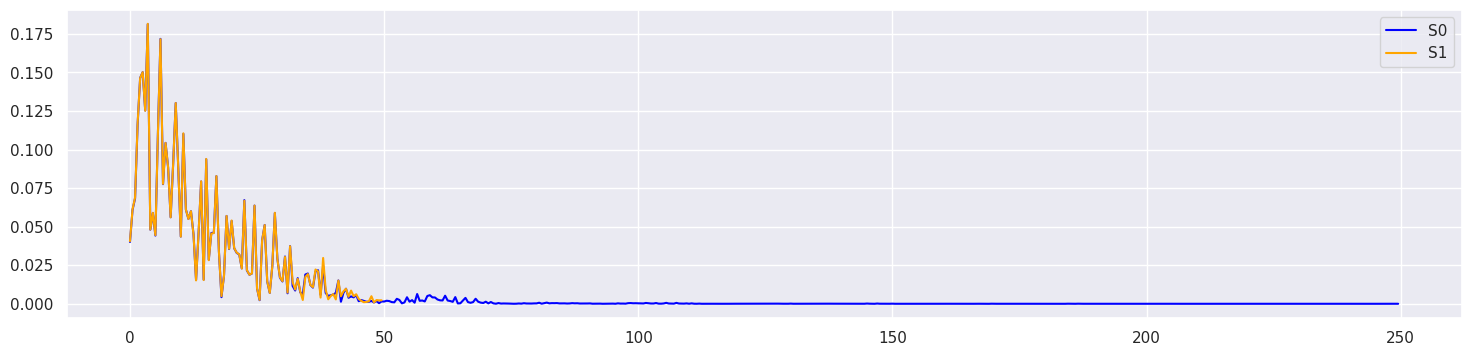

In [38]:
#Aparentemente algumas frequências foram ignoradas, justamente pela subamostragem "perder" certas informações do sinal.
#O próximo passo é comparar a reconstrução usando Shannon Basis para ver até que ponto conseguimos reconstruir este sinal gerado.
#O que foi possível observar até aqui é que quando o fator de amostragem diminui (gera mais pontos amostrados), o sinal é melhor ajustado ao original.
plot_fft1D([p_noise, p_noise_subsampling], width=18, height=4)

* Use the sinc basis to reconstruct the noise signal and compare the original signal to the reconstructed signal. Can you spot any alising artifacts? If so, describe them.

In [39]:
#Reconstruindo o sinal original
total_samples = len(p_noise_subsampling.values)
n_reconst = 1000
start_value, end_value = -1, 1 #Intervalo
reconst_grid_x = get_mgrid(n_reconst, dim=1, start=start_value, end=end_value) #Amostra o intervalo de pontos a serem reconstruídos (Eixo X vai ser a distribuição)
reconst_grid_x = torch.reshape(reconst_grid_x, (-1,))                          #Converter em um vetor 1D. Ex: [[1], [2]] -> [1, 2]

T = abs((start_value)-(end_value))/total_samples   #Intervalo de amostragem (que é o tamanho do intervalo |[-1,1]| = 2 dividido pela quantidade de amostras 'total_samples', ou seja, 2/100=0.02)
F = 1/T #Sendo F a frequencia e T o periodo

reconst_grid_y = shannon_reconstruction(reconst_grid_x, torch.reshape(p_noise_subsampling.values, (-1,)), total_samples, T, F)

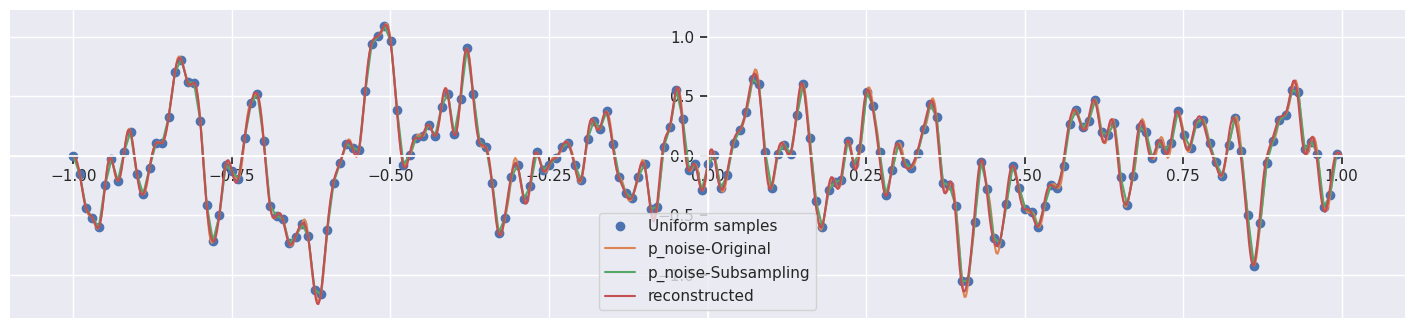

In [40]:
#Plota a função (sinal gerado e reconstruido)
multi_plot((p_noise_subsampling.coords, p_noise_subsampling.values), #Plotando os pontos amostrados
           [(p_noise.coords, p_noise.values), (p_noise_subsampling.coords, p_noise_subsampling.values), (reconst_grid_x, reconst_grid_y)], #Plotando os sinais
           ['p_noise-Original', 'p_noise-Subsampling', "reconstructed"], #Plotando as legendas
           width=18,
           height = 4)

In [41]:
#Aparentemente o sinal acima foi totalmente reconstruído, praticamente sem perdas.
#Caso o fator de amostragem aumente (o que geraria menos pontos amostrados) a reconstrução imprecisa do sinal seria observada.

* Check the FFT plot for both the original noise signal and the reconstructed noise signal.

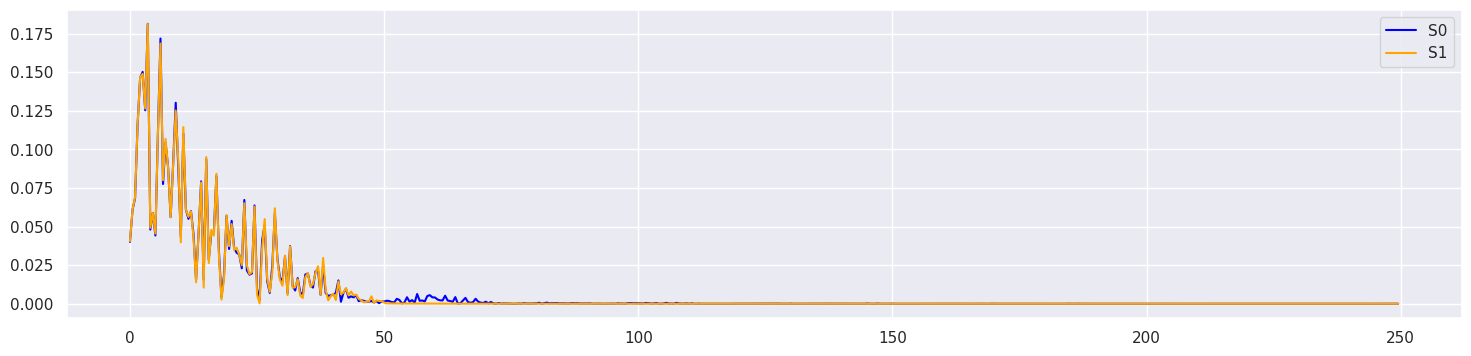

In [42]:
p_noise_reconstruction = Signal1D(reconst_grid_x, reconst_grid_y)
plot_fft1D([p_noise, p_noise_reconstruction], width=18, height=4)

#### **Conclusions:**

After exploring different parameters for generating Perlin noise, I chose a signal composed of several frequencies to better understand how the Nyquist-Shannon theorem works in a more realistic scenario. I applied the theorem to reconstruct the generated signal. Once again, it was possible to observe that the reconstruction was performed with almost no loss, both in the spatial and spectral domain. Aliasing only appeared when the Nyquist limit was not considered. In such cases, it is important to analyze the signal and its properties carefully to avoid inaccurate reconstruction.

## 2.2 Aliasing Artifacts in Images

Download the image of a striped t-shirt using the code below, then load and display the image.

In [43]:
# download image
!wget https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg

--2023-04-16 20:08:53--  https://raw.githubusercontent.com/hallpaz/3dsystems23/main/data/camisa.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255515 (250K) [image/jpeg]
Saving to: ‘camisa.jpg’

camisa.jpg          100%[===================>] 249.53K  --.-KB/s    in 0.004s  

2023-04-16 20:08:53 (68.6 MB/s) - ‘camisa.jpg’ saved [255515/255515]



* Convert the image to a tensor or numpy array representation and naively subsample it by a factor of 8. After checking the result, can you see any alising artifacts? Explain.

* Try a higher subsampling factor. Does it display more artifacts?

If you prefer, you can resize the image to a bigger size using the following snippet:

```python
# img is a numpy array that contains the pixels values
# dim is the new size; e.g. 513
Image.fromarray(img).resize((dim, dim), Image.BICUBIC)
```

In [44]:
#Carregando a imagem Original
tshirtOriginal = Image.open('/content/camisa.jpg')

#Convertendo a imagem em array
tshirtArray = np.array(tshirtOriginal)

In [45]:
#Criando subamostragens da imagem original
tshirt1025 = Image.fromarray(tshirtArray).resize((512, 512), Image.BICUBIC)
tshirt513  = Image.fromarray(tshirtArray[::2,::2,:]).resize((512, 512), Image.BICUBIC)    #Subsampling using Factor = 2
tshirt257  = Image.fromarray(tshirtArray[::4,::4,:]).resize((512, 512), Image.BICUBIC)    #Subsampling using Factor = 4
tshirt129  = Image.fromarray(tshirtArray[::8,::8,:]).resize((512, 512), Image.BICUBIC)    #Subsampling using Factor = 8
tshirt65   = Image.fromarray(tshirtArray[::16,::16,:]).resize((512, 512), Image.BICUBIC)  #Subsampling using Factor = 16
tshirt33   = Image.fromarray(tshirtArray[::32,::32,:]).resize((512, 512), Image.BICUBIC)  #Subsampling using Factor = 32

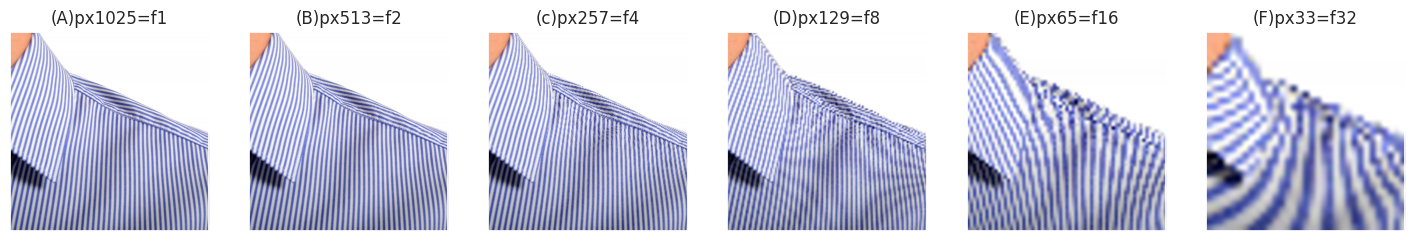

In [46]:
images = [tshirt1025, tshirt513, tshirt257, tshirt129, tshirt65, tshirt33]
labels = ["(A)px1025=f1", "(B)px513=f2", "(c)px257=f4", "(D)px129=f8", "(E)px65=f16", "(F)px33=f32"]
width = 6
f, axarr = plt.subplots(1,width, figsize=(18,10))
for i in range(width):
  axarr[i].imshow(images[i])
  axarr[i].title.set_text(labels[i])
  axarr[i].get_xaxis().set_ticks([])
  axarr[i].get_yaxis().set_ticks([])

#### **Conclusions:**

It is possible to observe the aliasing effect occurring in the above images when the sampling factor increases. While image (A) with 1025x1025 pixels has more well-defined details, periodic noise appears in images such as (D), (E), and (F), depending on the subsampling factor. Interestingly, when the image is subsampled by a factor of 16 or 32, the patterns on the t-shirt change considerably (see images (E) and (F)).

# 3 Fitting an 2D signal (image) using a neural network

In the previous assignment, you learned how to train a neural network to fit a 1D function using the basic components in the PyTorch framework. Now, we are going to solve a similar problem, but in 2D.



In [61]:
def get_cameraman_tensor(sidelength):
    img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(img)
    return img

class ImageSignal(Dataset):
    def __init__(self, sidelength, path=None):
        super().__init__()
        if path is None:
          img = get_cameraman_tensor(sidelength)
        else:
          img = Image.open(path).convert('L').resize((sidelength, sidelength))
          img = to_tensor(img)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.dim = sidelength

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
            
        return self.coords, self.pixels

class ReLuNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, coords):
        output = self.layers(coords)
        return output

def plot_tensor_img(output, dim, return_img=False):
    img = output.cpu().view(dim, dim).detach().numpy()
    if return_img:
        return img
    plt.grid(False)
    plt.imshow(img, cmap='gray')

def train(model, dataloader, epochs, device, steps_til_summary=100, gif_path=""):
    model.to(device)
    model.train()
    optim = torch.optim.Adam(lr=1e-4, params=model.parameters())
    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)
    
    dim = int(np.sqrt(len(ground_truth.view(-1))))
    if gif_path:
        writer = imageio.get_writer(gif_path, mode='I', duration=0.3)

    for step in range(epochs):
        model_output = model(model_input)    
        loss = ((model_output - ground_truth)**2).mean()

        if not (step % steps_til_summary):
            print("Step %d, Total loss %0.6f" % (step, loss))
            plot_tensor_img(model_output, dim)

        if gif_path and (step % 200 == 0):
            img = np.clip(model_output.cpu().view(dim, dim).detach().numpy(), 0, 1) 
            writer.append_data(np.uint8(img * 255))

        optim.zero_grad()
        loss.backward()
        optim.step()
    # last inference
    model.eval()
    model_output = model(model_input)
    img = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
    writer.append_data(np.uint8(img * 255))
    writer.close()

## 3.1 Training a regular MLP using ReLu as activation function

* Train a model using the ReLuNetwork provided in code cell above. Try to fit at least 2 images. What do you observe in the result?

* **[Optional]** Can you do better? Experiment different activation functions and/or a different set of hyperparameters and try to improve the result. Feel free to change the network architecture.



In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"running on {device}")

running on cuda


### First Image Approximation (Cameraman)

In [84]:
model = ReLuNetwork().to(device) #Aloca memória na GPU e copia os dados para lá.

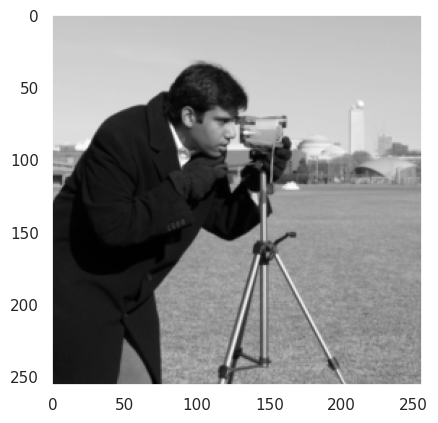

In [85]:
first_image = ImageSignal(256)
plot_tensor_img(first_image.pixels, first_image.dim)

In [86]:
dataloader = DataLoader(first_image)

In [87]:
epochs = 3001
steps_til_summary=500
gif_path = "./01_ReLU_first_image_approximation.gif"

Step 0, Total loss 0.327176
Step 500, Total loss 0.037128
Step 1000, Total loss 0.026249
Step 1500, Total loss 0.022894
Step 2000, Total loss 0.021165
Step 2500, Total loss 0.019730
Step 3000, Total loss 0.018722


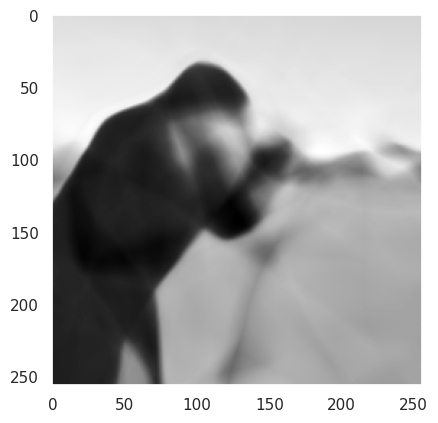

In [88]:
train(model, dataloader, epochs, device, steps_til_summary, gif_path)

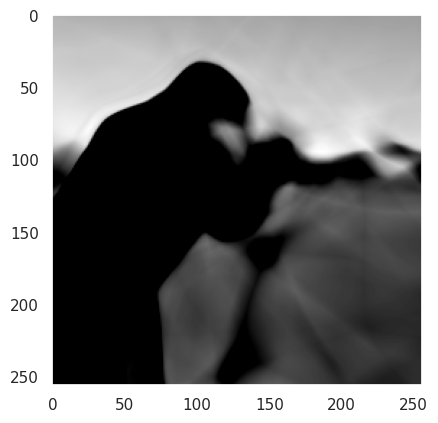

In [89]:
#Obtendo a imagem de saída após a aproximação gerada
model.to(device)
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
dim = int(np.sqrt(len(ground_truth.view(-1))))
model.eval()
model_output = model(model_input)
img1 = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
#Visualização
plt.grid(False)
plt.imshow(img1, cmap='gray')

### My Image Approximation (Sherlon)

In [90]:
import gdown

#Realizando download dos dados do Google Drive
!gdown --id '1wOd5NHFXmG6NGU9mxbRUs8JkPcHNV0f2' #id do link de compartilhamento

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1wOd5NHFXmG6NGU9mxbRUs8JkPcHNV0f2
To: /content/my_image.jpg
100% 303k/303k [00:00<00:00, 143MB/s]


In [91]:
model = ReLuNetwork().to(device) #Aloca memória na GPU e copia os dados para lá.

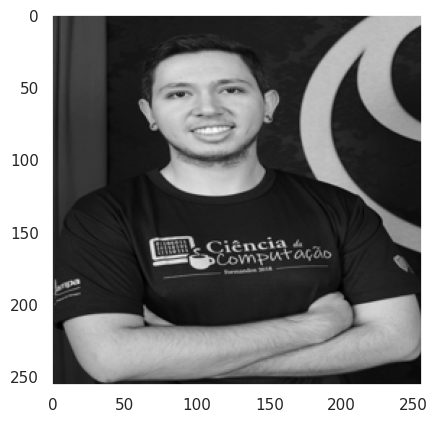

In [92]:
my_image = ImageSignal(256, "./my_image.jpg")
plot_tensor_img(my_image.pixels, my_image.dim)

In [93]:
dataloader = DataLoader(my_image)

In [94]:
epochs = 3001
steps_til_summary=500
gif_path = "./02_ReLU_my_image_approximation.gif"

Step 0, Total loss 0.208260
Step 500, Total loss 0.019505
Step 1000, Total loss 0.012815
Step 1500, Total loss 0.009584
Step 2000, Total loss 0.008334
Step 2500, Total loss 0.007563
Step 3000, Total loss 0.006994


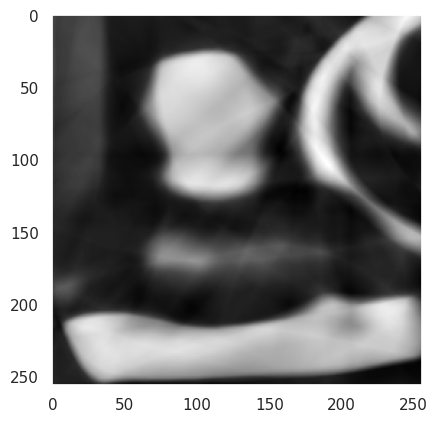

In [95]:
train(model, dataloader, epochs, device, steps_til_summary, gif_path)

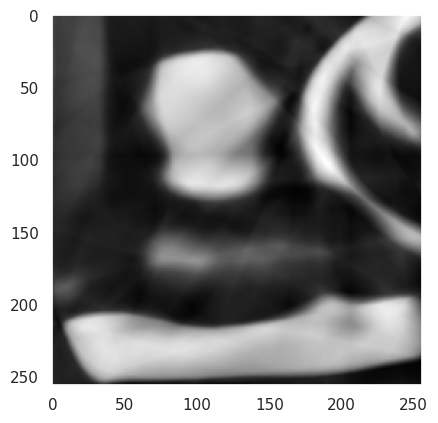

In [96]:
#Obtendo a imagem de saída após a aproximação gerada
model.to(device)
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
dim = int(np.sqrt(len(ground_truth.view(-1))))
model.eval()
model_output = model(model_input)
img2 = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
#Visualização
plt.grid(False)
plt.imshow(img2, cmap='gray')

#### **Conclusions:**

It is possible to observe that the images approximated using RELU are smoother than the original. Let's plot the image spectra below to observe what kind of signals were learned.

## 3.2 Fourier Transform of Images

In [119]:
#Sherlon: Adaptei a função para retornar a imagem depois da transformação
def plot_fft2D(pixels:torch.Tensor, dim, return_img=False):
    fourier_tensor = torch.fft.fftshift(
                    torch.fft.fft2(pixels.view(dim, dim).squeeze(-1)))
    magnitude = 20 * np.log(abs(fourier_tensor.numpy()) + 1e-10)
    mmin = np.min(magnitude)
    magnitude = (magnitude - mmin) / (np.max(magnitude) - mmin)
    img = np.uint8(magnitude * 255)
    if return_img:
      return img
    plt.grid(False)
    plt.imshow(img, cmap='gray')
  
#Sherlon: Criei uma função similar à função acima, porém que permite gerar o Spectro de imagens 2D e não tensores
def get_fourier_spectrum(img):
    fourier_tensor = torch.fft.fftshift(torch.fft.fft2(torch.tensor(img))) # pixels.view(dim, dim).squeeze(-1)))
    magnitude = 20 * np.log(abs(fourier_tensor.numpy()) + 1e-10)
    mmin = np.min(magnitude)
    magnitude = (magnitude - mmin) / (np.max(magnitude) - mmin)
    img_fft = np.uint8(magnitude * 255)
    return img_fft

The code above computes the Fast Fourier Transform of a 2D image and displays the magnitude of the FFT as another image. The lower frequencies will appear near the center of the image while the higher frequencies will appear near the border of the image. The magnitude is normalized for better visualization.

### Observing Image 1 (Cameraman)

In [122]:
#Imagem original
cameraman = ImageSignal(256)
cameraman_spatial = plot_tensor_img(cameraman.pixels, cameraman.dim, return_img=True)
#FFT da Imagem original
cameraman_fft = plot_fft2D(cameraman.pixels, cameraman.dim, return_img=True)
#Imagem aproximada com Relu (É a imagem img1 gerada anteriormente)
#FFT da Imagem aproximada com Relu
img1_fft = get_fourier_spectrum(img1)

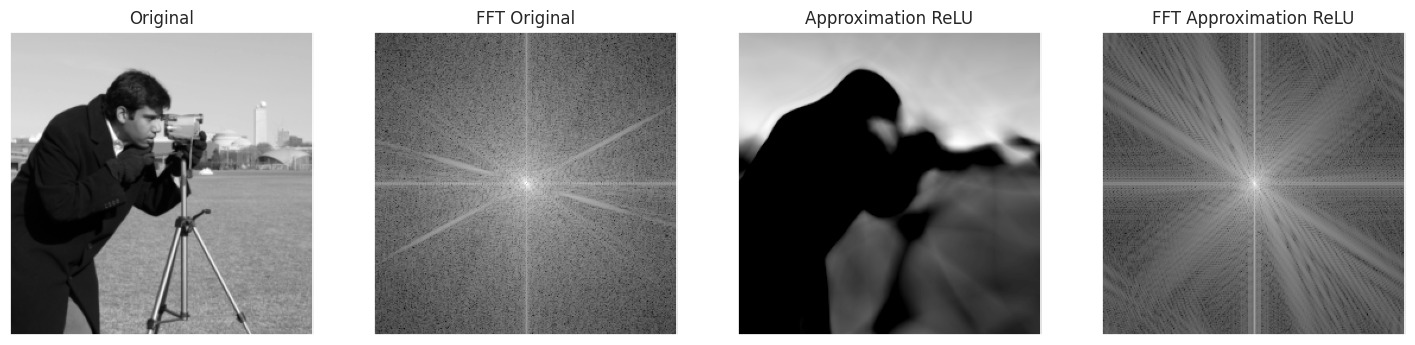

In [123]:
images = [cameraman_spatial, cameraman_fft, img1, img1_fft]
labels = ["Original", "FFT Original", "Approximation ReLU", "FFT Approximation ReLU"]
width = 4
f, axarr = plt.subplots(1,width, figsize=(18,10))
for i in range(width):
  axarr[i].imshow(images[i], cmap='gray')
  axarr[i].title.set_text(labels[i])
  axarr[i].get_xaxis().set_ticks([])
  axarr[i].get_yaxis().set_ticks([])

### Observing Image 2 (Sherlon)

In [124]:
#Imagem original
my_image = ImageSignal(256, "./my_image.jpg")
my_image_spatial = plot_tensor_img(my_image.pixels, my_image.dim, return_img=True)
#FFT da Imagem original
my_image_fft = plot_fft2D(my_image.pixels, my_image.dim, return_img=True)
#Imagem aproximada com Relu (É a imagem img2 gerada anteriormente)
#FFT da Imagem aproximada com Relu
img2_fft = get_fourier_spectrum(img2)

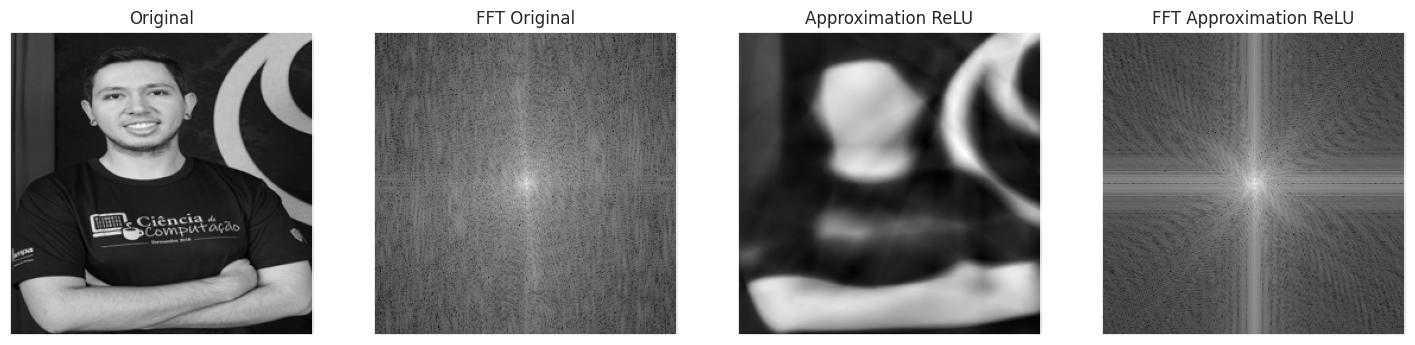

In [125]:
images = [my_image_spatial, my_image_fft, img2, img2_fft]
labels = ["Original", "FFT Original", "Approximation ReLU", "FFT Approximation ReLU"]
width = 4
f, axarr = plt.subplots(1,width, figsize=(18,10))
for i in range(width):
  axarr[i].imshow(images[i], cmap='gray')
  axarr[i].title.set_text(labels[i])
  axarr[i].get_xaxis().set_ticks([])
  axarr[i].get_yaxis().set_ticks([])

* Visualize the FFT of the result image of the trained model. How does it compare to the ground truth?

#### **Conclusions:**

It is possible to observe that the images approximated using RELU are smoother than the original. This suggests that the model may not be good at capturing the finer details in images. When observing the Fourier spectrum of the images, it becomes apparent that the middle frequencies (low frequencies) are preserved while the border frequencies (high frequencies) are lost. In other words, the details lost during the approximation correspond to the higher frequencies, while the lower frequencies maintain the overall appearance of the images.

## 3.3 Training a Sinusoidal Neural Network to fit an image

In [126]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        output = self.net(coords)
        return output

The code above defines a simplified version of a SIREN* (sinusoidal representation network. This kind of network uses sines as the activation function. 

Notice that it's not as trivial as changing $relu()$ for $sin()$, as it requires a special initialization to guarantee stability and convergence during training. You can find the paper and the original [code in this link](https://www.vincentsitzmann.com/siren/), and check the details.

* Train a Siren network to fit the same images you were working with. Is the result better? Explain.

* Use the FFT to analyze the frequencies learned by the network. Why do you think 

### First Image Approximation (Cameraman)

In [128]:
model = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=3).to(device) #Aloca memória na GPU e copia os dados para lá.

In [129]:
first_image = ImageSignal(256)

In [130]:
dataloader = DataLoader(first_image)

In [131]:
epochs = 3001
steps_til_summary=500
gif_path = "./03_Siren_first_image_approximation.gif"

Step 0, Total loss 0.742083
Step 500, Total loss 0.009191
Step 1000, Total loss 0.004552
Step 1500, Total loss 0.002806
Step 2000, Total loss 0.003433
Step 2500, Total loss 0.003515
Step 3000, Total loss 0.001115


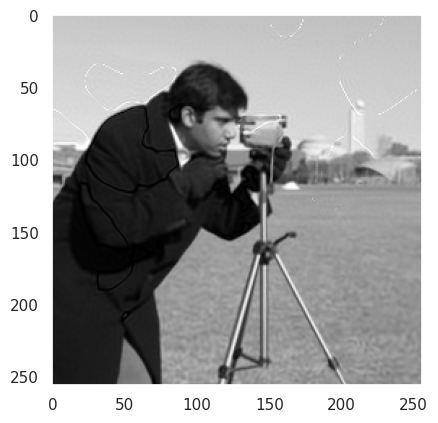

In [132]:
train(model, dataloader, epochs, device, steps_til_summary, gif_path)

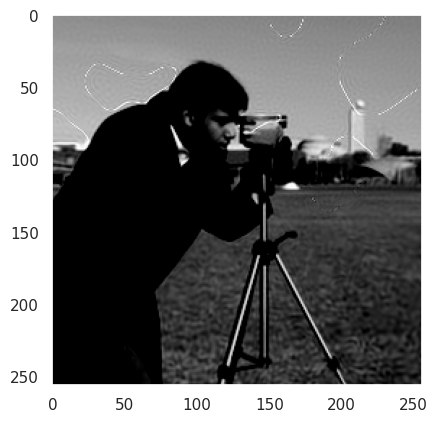

In [133]:
#Obtendo a imagem de saída após a aproximação gerada
model.to(device)
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
dim = int(np.sqrt(len(ground_truth.view(-1))))
model.eval()
model_output = model(model_input)
img3 = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
#Visualização
plt.grid(False)
plt.imshow(img3, cmap='gray')

### My Image Approximation (Sherlon)

In [134]:
model = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=3).to(device) #Aloca memória na GPU e copia os dados para lá.

In [136]:
my_image = ImageSignal(256, "./my_image.jpg")

In [137]:
dataloader = DataLoader(my_image)

In [138]:
epochs = 3001
steps_til_summary=500
gif_path = "./04_Siren_my_image_approximation.gif"

Step 0, Total loss 0.313916
Step 500, Total loss 0.012350
Step 1000, Total loss 0.004841
Step 1500, Total loss 0.002398
Step 2000, Total loss 0.001261
Step 2500, Total loss 0.000795
Step 3000, Total loss 0.000550


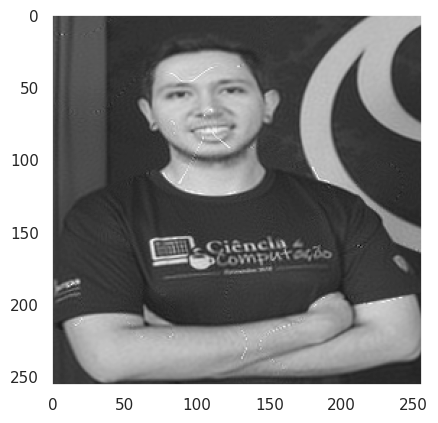

In [139]:
train(model, dataloader, epochs, device, steps_til_summary, gif_path)

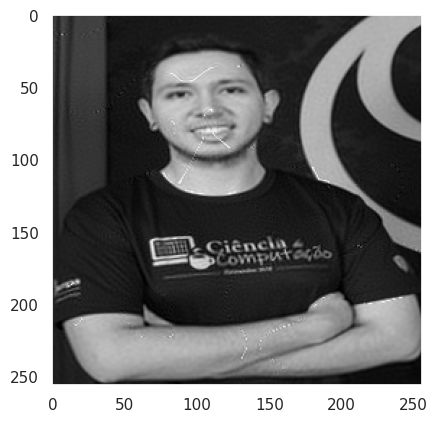

In [140]:
#Obtendo a imagem de saída após a aproximação gerada
model.to(device)
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)
dim = int(np.sqrt(len(ground_truth.view(-1))))
model.eval()
model_output = model(model_input)
img4 = np.clip(plot_tensor_img(model_output, dim, True), 0, 1)
#Visualização
plt.grid(False)
plt.imshow(img4, cmap='gray')

#### **Conclusions:**

It is possible to observe that the images approximated using sinusoidal activation functions can properly approximate signals. The intuition so far is that this type of model is more suitable for periodic data, such as 1D or 2D signals, by learning both low and high frequencies.

### Observing Image 1 (Cameraman)

In [141]:
#Imagem original
cameraman = ImageSignal(256)
cameraman_spatial = plot_tensor_img(cameraman.pixels, cameraman.dim, return_img=True)
#FFT da Imagem original
cameraman_fft = plot_fft2D(cameraman.pixels, cameraman.dim, return_img=True)
#Imagem aproximada com a Siren (É a imagem img3 gerada anteriormente)
#FFT da Imagem aproximada com Relu
img3_fft = get_fourier_spectrum(img3)

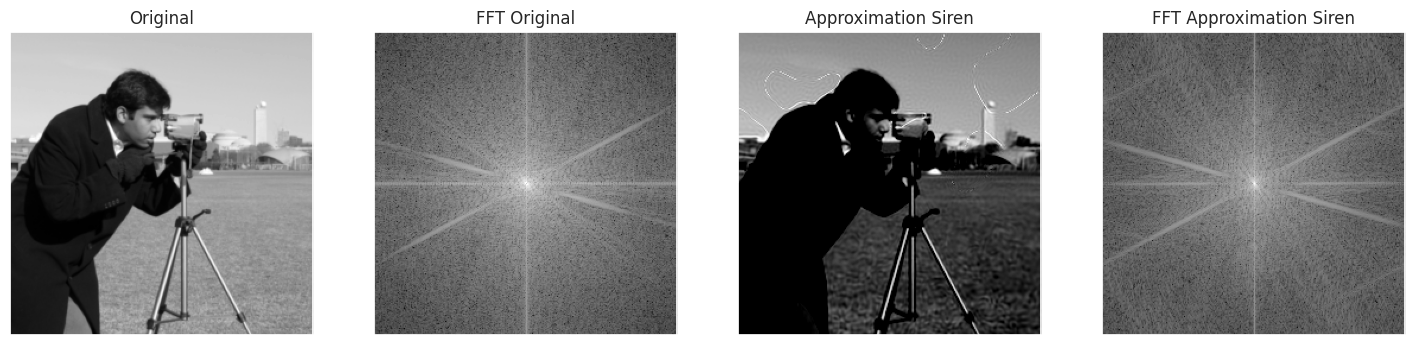

In [142]:
images = [cameraman_spatial, cameraman_fft, img3, img3_fft]
labels = ["Original", "FFT Original", "Approximation Siren", "FFT Approximation Siren"]
width = 4
f, axarr = plt.subplots(1,width, figsize=(18,10))
for i in range(width):
  axarr[i].imshow(images[i], cmap='gray')
  axarr[i].title.set_text(labels[i])
  axarr[i].get_xaxis().set_ticks([])
  axarr[i].get_yaxis().set_ticks([])

### Observing Image 2 (Sherlon)

In [143]:
#Imagem original
my_image = ImageSignal(256, "./my_image.jpg")
my_image_spatial = plot_tensor_img(my_image.pixels, my_image.dim, return_img=True)
#FFT da Imagem original
my_image_fft = plot_fft2D(my_image.pixels, my_image.dim, return_img=True)
#Imagem aproximada com a Siren (É a imagem img4 gerada anteriormente)
#FFT da Imagem aproximada com Relu
img4_fft = get_fourier_spectrum(img4)

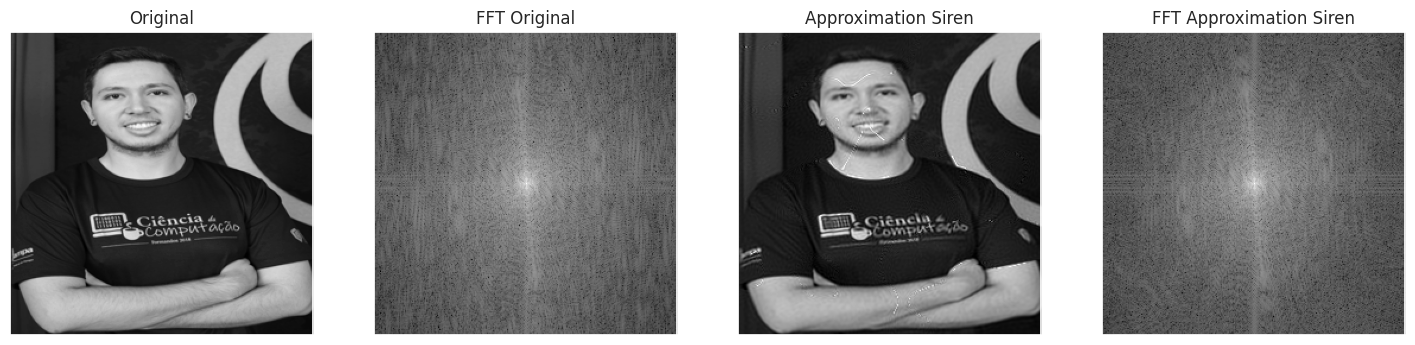

In [144]:
images = [my_image_spatial, my_image_fft, img4, img4_fft]
labels = ["Original", "FFT Original", "Approximation Siren", "FFT Approximation Siren"]
width = 4
f, axarr = plt.subplots(1,width, figsize=(18,10))
for i in range(width):
  axarr[i].imshow(images[i], cmap='gray')
  axarr[i].title.set_text(labels[i])
  axarr[i].get_xaxis().set_ticks([])
  axarr[i].get_yaxis().set_ticks([])

* Visualize the FFT of the result image of the trained model. How does it compare to the ground truth?

#### **Conclusions:**

It is possible to observe that the images approximated using Siren are excellent at capturing the finer details in images. When observing the Fourier spectrum of the images, it becomes apparent that both lower and higher frequencies are preserved. In other words, all of the information is preserved during the approximation process.

One of the most interesting observations from this assignment is that it's important to create models that are suitable for each type of data to preserve useful information. In this case, we compared the performance of a traditional architecture using ReLU against a more suitable architecture using a sinusoidal activation function. The results showed a considerable improvement with the Siren model.